In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # K邻近聚类
from sklearn.tree import DecisionTreeClassifier # 决策树分类
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit,cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import train_test_split,ShuffleSplit,learning_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_fea = pd.read_excel('train_fea.xlsx')
test_fea = pd.read_excel('test_fea.xlsx')

In [3]:
DropFeature = []

# 对特征进行分析处理

找到数值特征和类别特征

In [4]:

numerical_fea = list(train_fea.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train_fea.columns)))

In [5]:
#过滤连续型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:# 先以10为分界
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea

In [6]:
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train_fea,numerical_fea)

In [173]:
numerical_noserial_fea

['card_d_cnt',
 'service1_cnt',
 'service2_cnt',
 'p_oneDayOptChanType',
 'p_7DayOptChanType',
 '过去30天交易平台类型',
 'label']

查看缺失值-- 如果缺失值超过一半考虑不取这个特征

In [164]:
def nan_value_describe(data,name):
    count = data.isnull().any().sum()
    # print(f'There are {data.isnull().any().sum()} columns in dataset with missing values.')
    have_null_fea_dict = (data.isnull().sum()/len(data)).to_dict()
    fea_null_moreThanHalf = {}
    for key,value in have_null_fea_dict.items():
        if value > 0.5:
            fea_null_moreThanHalf[key] = value
    missing = data.isnull().sum()/len(data)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    print(missing.index)
    # plt.xticks(rotation=90)
    # missing.plot.bar()
    p1 = plt.bar(missing.index,missing.values)
    plt.savefig(name,dpi = 1000,bbox_inches='tight')
    print("缺失统计\n",missing)
    return fea_null_moreThanHalf,count

Index(['sex', 'balance_avg', 'balance1_avg', 'Std过去1天累计交易金额', 'Std过去30天累计交易金额',
       'Std过去7天累计交易金额', 'Std过去15天累计交易金额', 'service3_level'],
      dtype='object')
缺失统计
 sex               0.004323
balance_avg       0.006344
balance1_avg      0.006344
Std过去1天累计交易金额     0.075847
Std过去30天累计交易金额    0.120223
Std过去7天累计交易金额     0.121622
Std过去15天累计交易金额    0.135523
service3_level    0.918680
dtype: float64


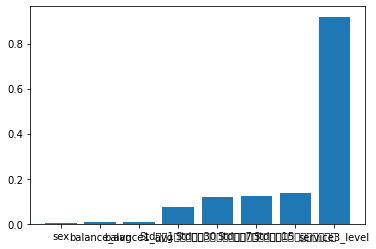

In [13]:
fea_null_moreThanHalf_tr_base,count = nan_value_describe(data_train,'base.jpg')

Index(['sex', 'balance_avg', 'balance1_avg', 'service3_level'], dtype='object')
缺失统计
 sex               0.004800
balance_avg       0.005760
balance1_avg      0.005760
service3_level    0.915648
dtype: float64


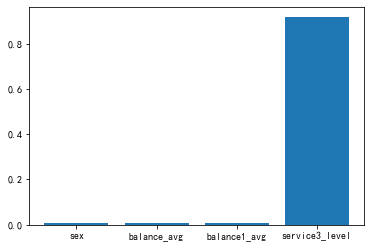

In [178]:
fea_null_moreThanHalf_ts_base,count = nan_value_describe(data_test,'test.jpg')

In [16]:
DropFeature.append(list(fea_null_moreThanHalf_tr_base.keys()))

In [18]:
# 唯一值变量
one_value_fea = [col for col in train_fea.columns if train_fea[col].nunique() <= 1]

In [19]:
one_value_fea

[]

In [20]:
# 数值型变量
numerical_noserial_fea

['card_d_cnt',
 'service1_cnt',
 'service2_cnt',
 'p_oneDayOptChanType',
 'p_7DayOptChanType',
 '过去30天交易平台类型',
 'label']

In [21]:
train_fea['card_d_cnt'].value_counts()

24706    27659
24712     4228
24719      239
24725       31
Name: card_d_cnt, dtype: int64

In [22]:
train_fea['service1_cnt'].value_counts() # 偏离得比较多

24706    31549
24712      580
24719       21
24725        4
24731        1
24737        1
24785        1
Name: service1_cnt, dtype: int64

In [23]:
DropFeature.append('service1_cnt')

In [24]:
train_fea['service2_cnt'].value_counts() 

24706    31585
24712      553
24719       14
24725        2
24737        2
24731        1
Name: service2_cnt, dtype: int64

In [25]:
DropFeature.append('service2_cnt')

In [26]:
train_fea['p_oneDayOptChanType'].value_counts() 

0    21647
2     6175
3     2955
4      634
1      620
5      109
6       16
7        1
Name: p_oneDayOptChanType, dtype: int64

In [27]:
train_fea['p_7DayOptChanType'].value_counts() 

0    11436
2    10454
3     6675
4     2150
1      688
5      608
6      118
7       25
8        2
9        1
Name: p_7DayOptChanType, dtype: int64

In [28]:
train_fea['过去30天交易平台类型'].value_counts() 

2    13156
1     8687
3     5109
0     4192
4     1001
5       12
Name: 过去30天交易平台类型, dtype: int64

In [18]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 连续变量的分布统计

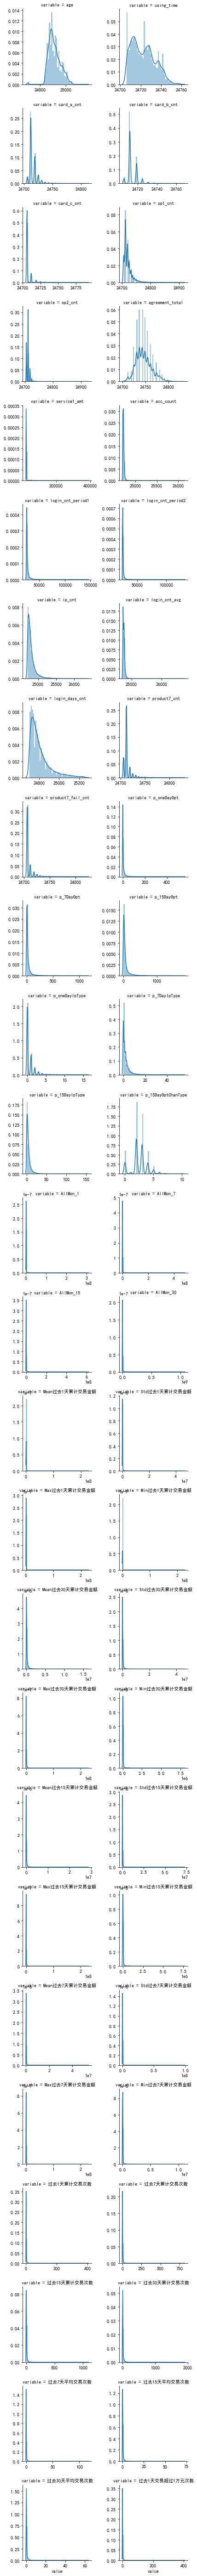

In [34]:
f = pd.melt(train_fea, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [ ]:
# 城市类别特征处理

# 变量分布可视化

In [104]:
numerical_fea

['age',
 'using_time',
 'card_a_cnt',
 'card_b_cnt',
 'card_c_cnt',
 'op1_cnt',
 'op2_cnt',
 'card_d_cnt',
 'agreement_total',
 'service1_cnt',
 'service1_amt',
 'service2_cnt',
 'acc_count',
 'login_cnt_period1',
 'login_cnt_period2',
 'ip_cnt',
 'login_cnt_avg',
 'login_days_cnt',
 'product7_cnt',
 'product7_fail_cnt',
 'p_oneDayOpt',
 'p_7DayOpt',
 'p_15DayOpt',
 'p_oneDayIpType',
 'p_7DayIpType',
 'p_15DayIpType',
 'p_oneDayOptChanType',
 'p_7DayOptChanType',
 'p_15DayOptChanType',
 'AllMon_1',
 'AllMon_7',
 'AllMon_15',
 'AllMon_30',
 'Mean过去1天累计交易金额',
 'Std过去1天累计交易金额',
 'Max过去1天累计交易金额',
 'Min过去1天累计交易金额',
 'Mean过去30天累计交易金额',
 'Std过去30天累计交易金额',
 'Max过去30天累计交易金额',
 'Min过去30天累计交易金额',
 'Mean过去15天累计交易金额',
 'Std过去15天累计交易金额',
 'Max过去15天累计交易金额',
 'Min过去15天累计交易金额',
 'Mean过去7天累计交易金额',
 'Std过去7天累计交易金额',
 'Max过去7天累计交易金额',
 'Min过去7天累计交易金额',
 '过去1天累计交易次数',
 '过去7天累计交易次数',
 '过去15天累计交易次数',
 '过去30天累计交易次数',
 '过去7天平均交易次数',
 '过去15天平均交易次数',
 '过去30天平均交易次数',
 '过去30天交易平台类型',
 '过去1天交易超过1万元次数',
 'label']

In [60]:
category_fea

['user',
 'sex',
 'provider',
 'level',
 'verified',
 'regist_type',
 'agreement1',
 'agreement2',
 'agreement3',
 'agreement4',
 'province',
 'city',
 'balance',
 'balance_avg',
 'balance1',
 'balance1_avg',
 'balance2',
 'balance2_avg',
 'service3',
 'service3_level',
 'product1_amount',
 'product2_amount',
 'product3_amount',
 'product4_amount',
 'product5_amount',
 'product6_amount']

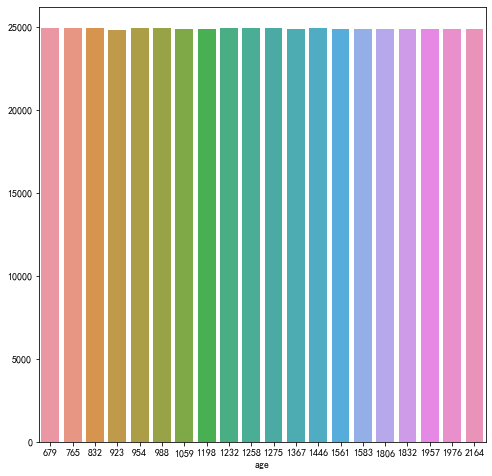

In [129]:
# 对类别特征做可视化
plt.figure(figsize=(8, 8))
sns.barplot(train_fea["age"].value_counts(dropna=False)[:20],
            train_fea["age"].value_counts(dropna=False).keys()[:20])
plt.show()

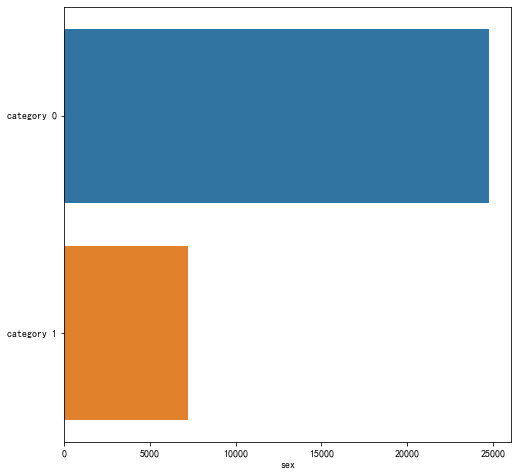

In [130]:
# 对类别特征做可视化
plt.figure(figsize=(8, 8))
sns.barplot(train_fea["sex"].value_counts(dropna=False),
            train_fea["sex"].value_counts(dropna=False).keys())
plt.show()

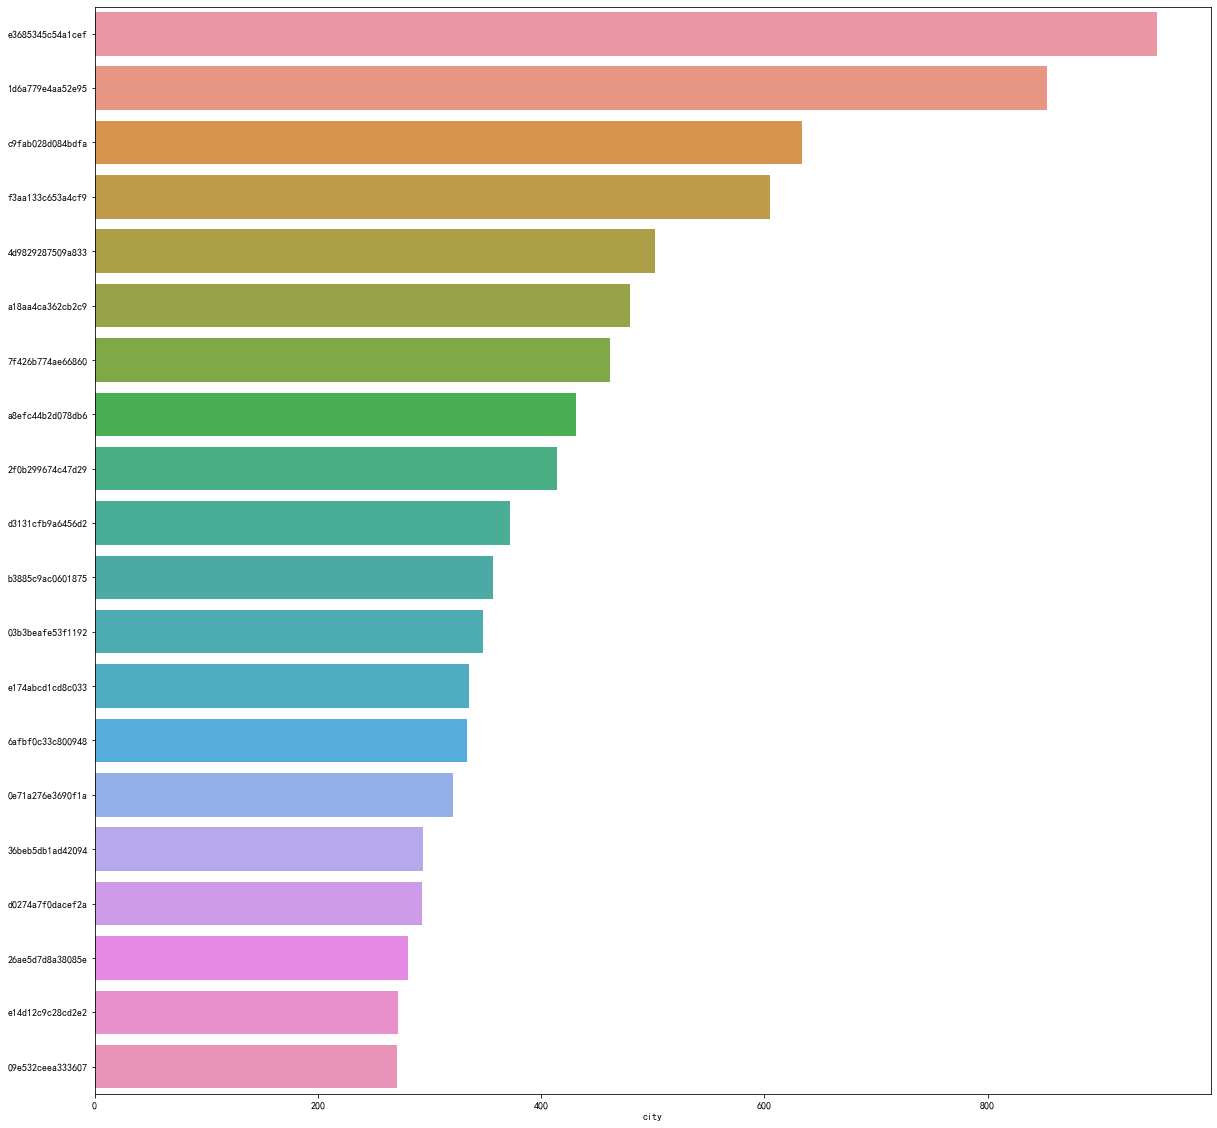

In [134]:
# 对类别特征做可视化
plt.figure(figsize=(20, 20))
sns.barplot(train_fea["city"].value_counts(dropna=False)[:20],
            train_fea["city"].value_counts(dropna=False).keys()[:20])
plt.show()

In [23]:
train_loan_fr = train_fea.loc[train_fea['label'] == 1]
train_loan_nofr = train_fea.loc[train_fea['label'] == 0]

### 考虑是否加入’高危城市标记‘

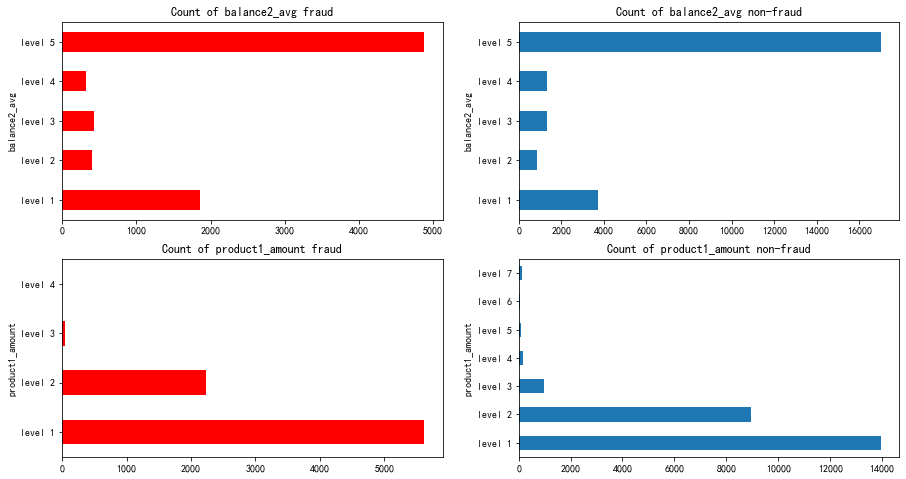

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

train_loan_fr.groupby('balance2_avg')['balance2_avg'].count().plot(kind='barh', ax=ax1, color = 'red',title='Count of balance2_avg fraud')
train_loan_nofr.groupby('balance2_avg')['balance2_avg'].count().plot(kind='barh', ax=ax2, title='Count of balance2_avg non-fraud')

train_loan_fr.groupby('product1_amount')['product1_amount'].count().plot(kind='barh', ax=ax3,  color = 'red',title='Count of product1_amount fraud')
train_loan_nofr.groupby('product1_amount')['product1_amount'].count().plot(kind='barh', ax=ax4,title='Count of product1_amount non-fraud')

plt.show()

In [103]:
cityCountFraud = train_loan_fr.groupby('city')['city'].count().to_dict()
cityCountFraud = sorted(cityCountFraud.items(), key = lambda x:(x[1], x[0]))

In [100]:
cityRank = pd.DataFrame(cityCountFraud)

In [102]:
cityRank.describe()

,1
count,344.000000
mean,22.936047
std,28.396536
min,1.000000
25%,7.000000
50%,16.000000
75%,27.000000
max,228.000000


<AxesSubplot:title={'center':'AllMon_1 - Not Fraud'}, ylabel='Frequency'>

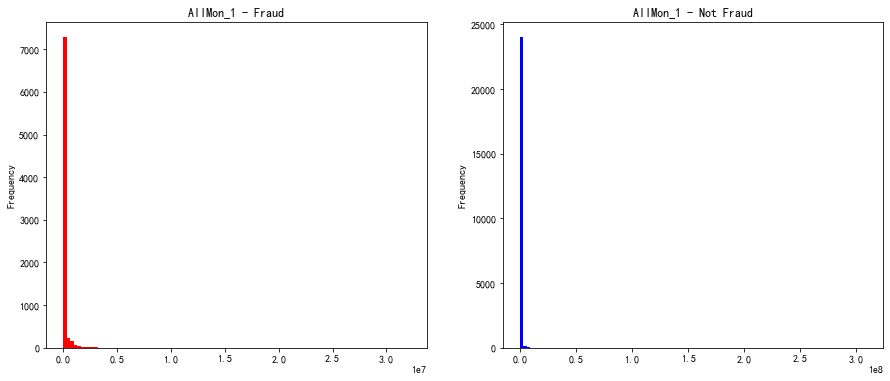

In [39]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
train_fea.loc[train_fea['label'] == 1] \
    ['AllMon_1'] \
    .plot(kind='hist',
          bins=100,
          title='AllMon_1 - Fraud',
          color='r',
         ax= ax1)
train_fea.loc[train_fea['label'] == 0] \
    ['AllMon_1'] \
    .plot(kind='hist',
          bins=100,
          title='AllMon_1 - Not Fraud',
          color='b',
         ax=ax2)

In [19]:
def plot_dis_num(fea):
    # 连续变量对于不同标签的分布情况
    total = len(train_fea)
    total_amt = train_fea.groupby(['label'])[fea].sum().sum()
    plt.figure(figsize=(12,5))

    plt.subplot(121)#1代表行，2代表列，所以一共有2个图，1代表此时绘制第一个图。

    plot_tr = sns.countplot(x='label',data=train_fea)#train_fea‘isDefault’这个特征每种类别的数量**

    plot_tr.set_title("Fraud Loan Distribution \n 0: good user | 1: bad user", fontsize=14)
    plot_tr.set_xlabel("Is fraud by count", fontsize=16)
    plot_tr.set_ylabel('Count', fontsize=16)

    for p in plot_tr.patches:
        height = p.get_height()
        plot_tr.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 
    percent_amt = (train_fea.groupby(['label'])[fea].sum())
    percent_amt = percent_amt.reset_index()


    plt.subplot(122)
    plot_tr_2 = sns.barplot(x='label', y=fea,  dodge=True, data=percent_amt)
    plot_tr_2.set_title("Total Amount in "+fea+"  \n 0: good user | 1: bad user", fontsize=14)
    plot_tr_2.set_xlabel("Is fraud by percent", fontsize=16)
    plot_tr_2.set_ylabel('Total Loan Amount Scalar', fontsize=16)
    
    for p in plot_tr_2.patches:
        height = p.get_height()
        plot_tr_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt * 100),
                ha="center", fontsize=15)     

In [38]:
train_fea.groupby(['label'])['AllMon_15'].sum()

label
0    32651616282
1     3995676893
Name: AllMon_15, dtype: int64

ValueError: cannot insert label, already exists

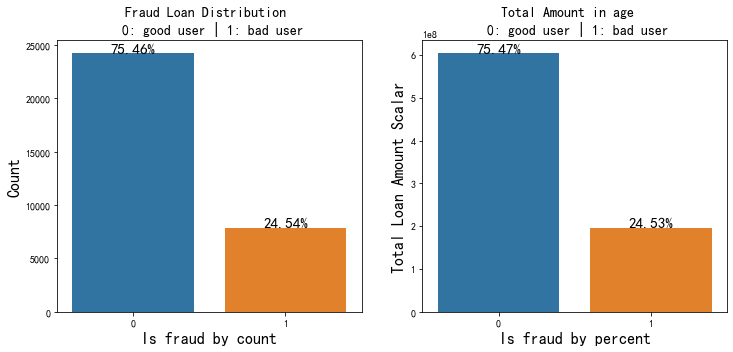

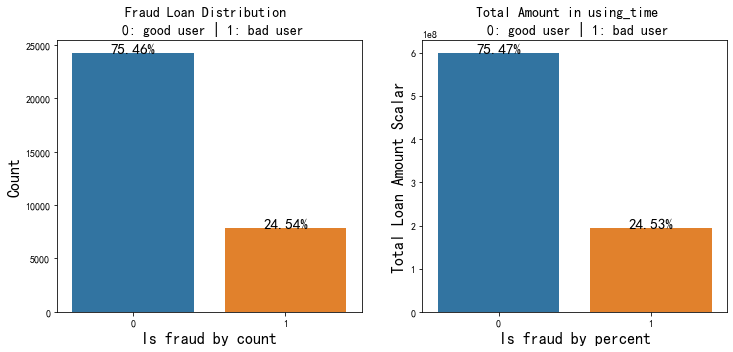

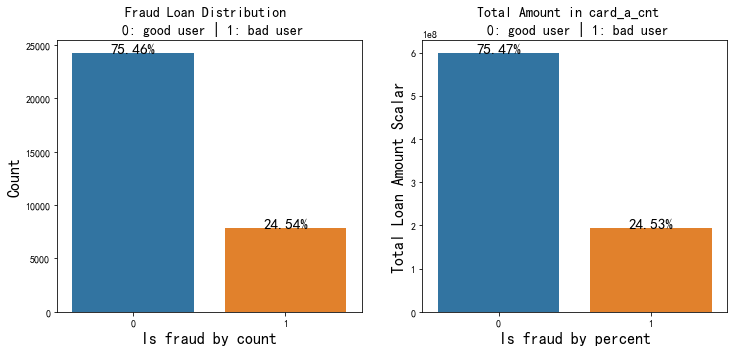

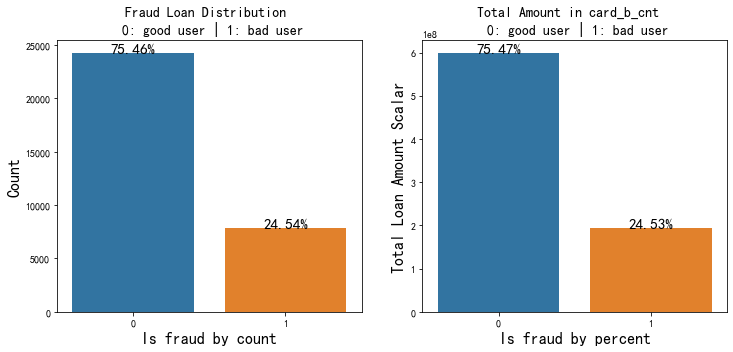

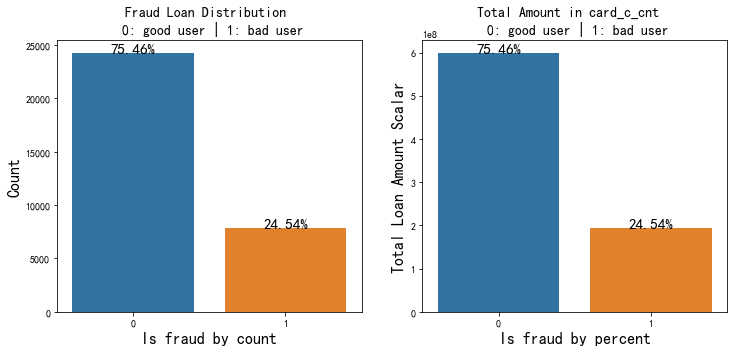

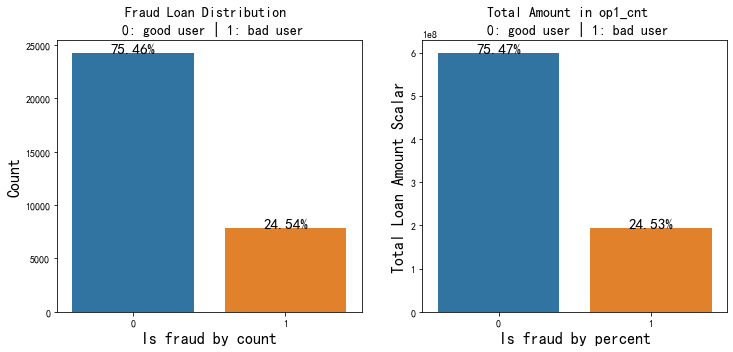

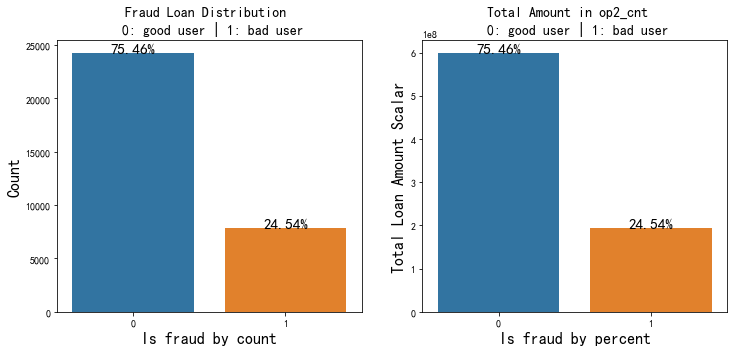

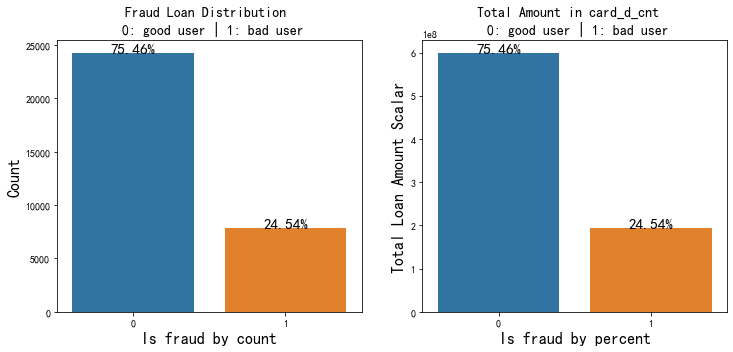

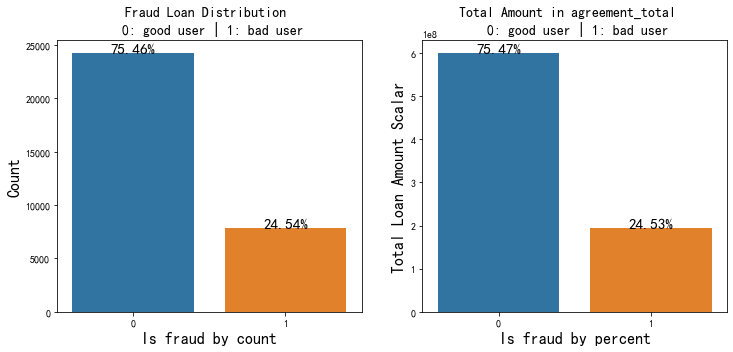

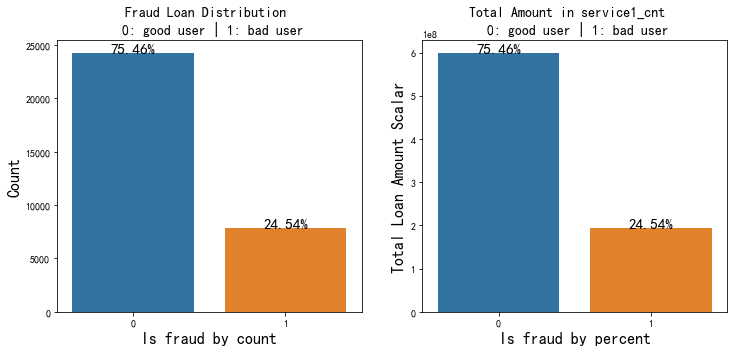

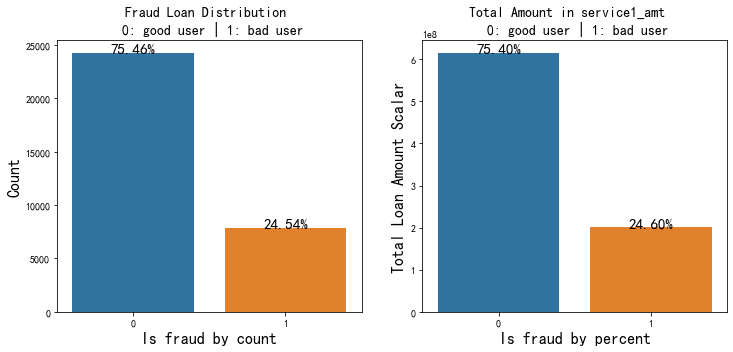

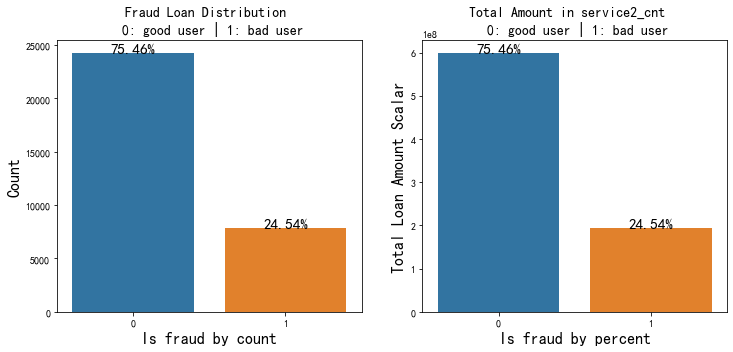

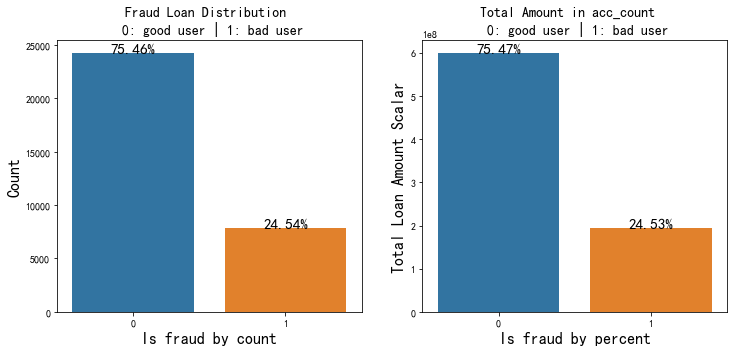

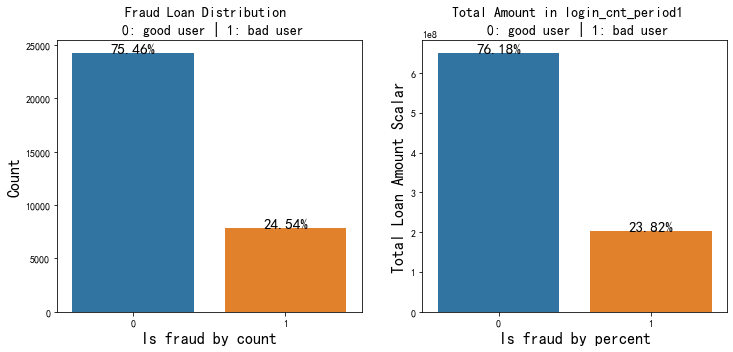

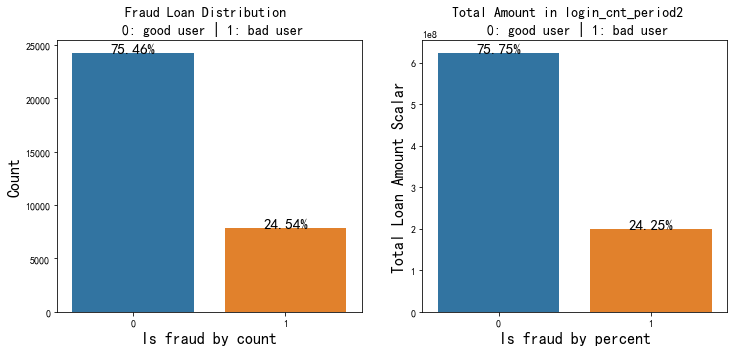

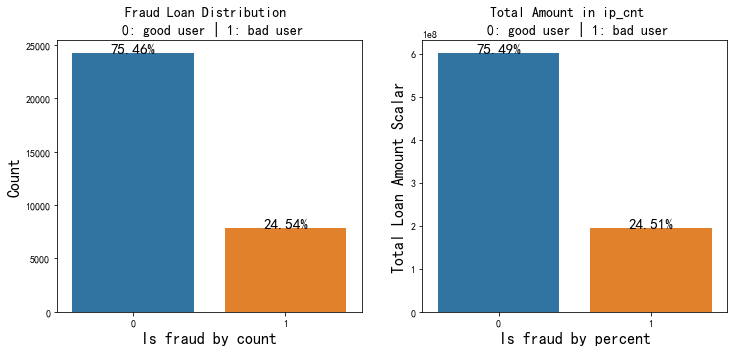

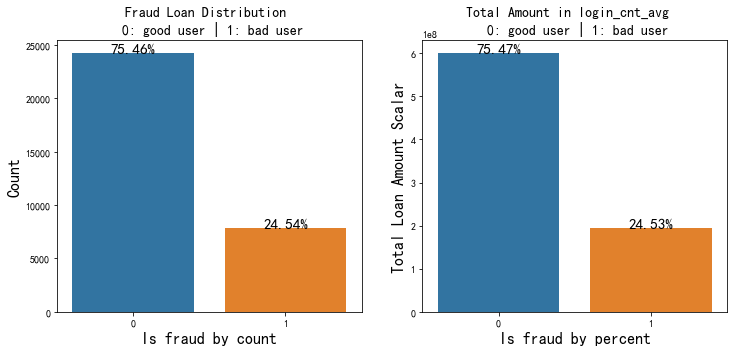

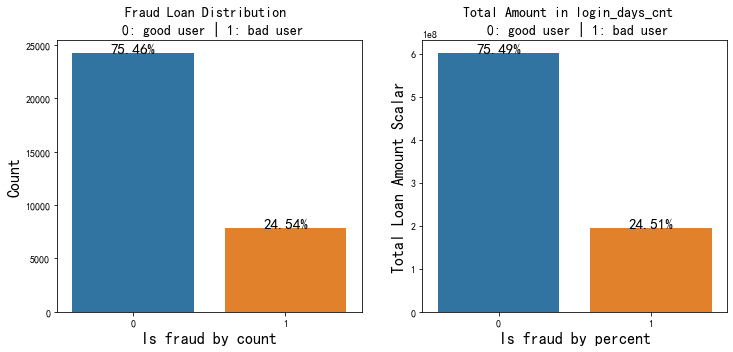

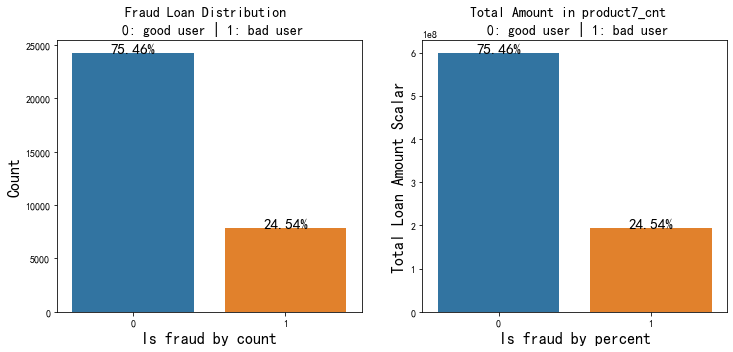

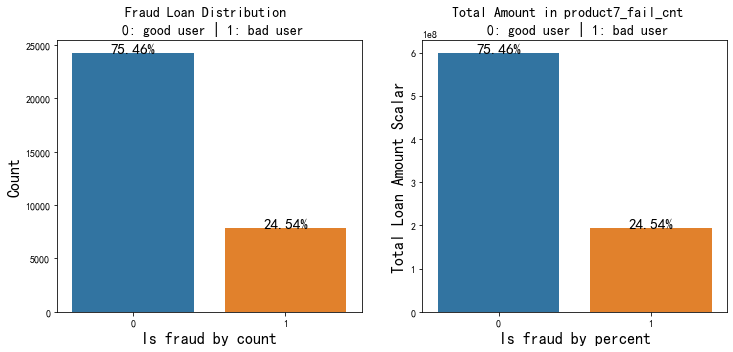

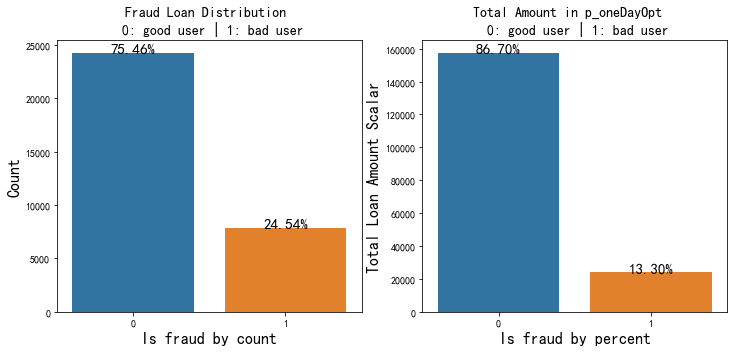

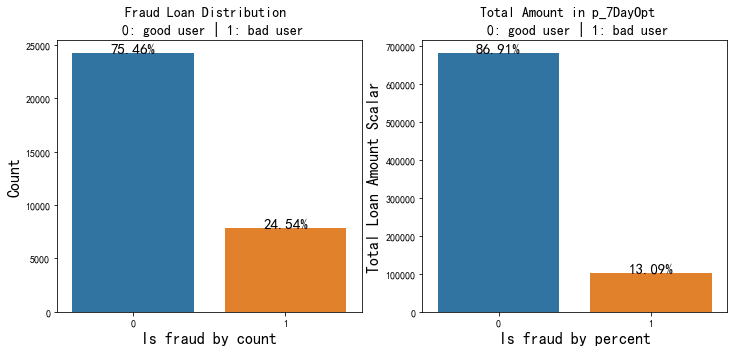

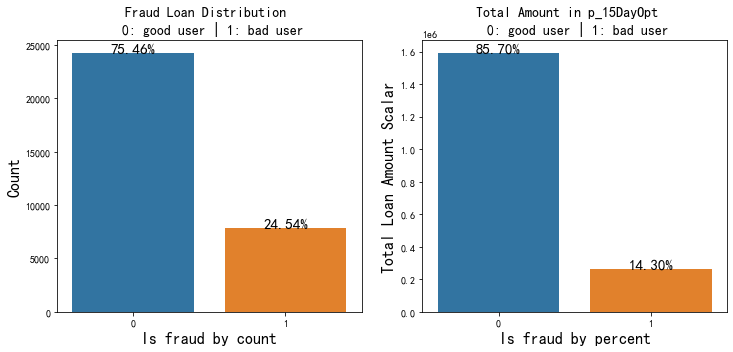

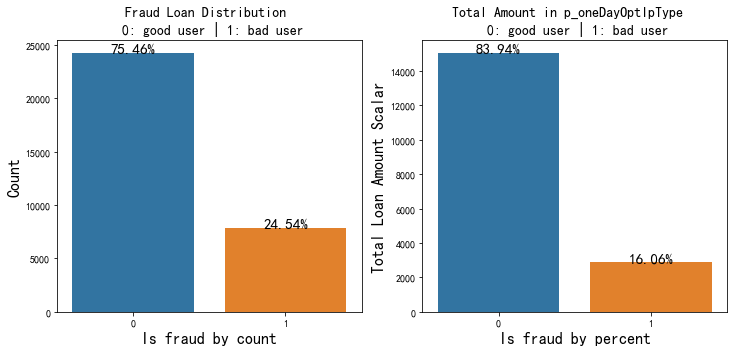

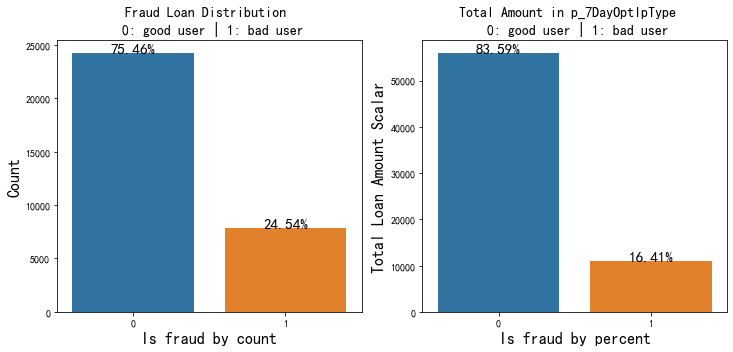

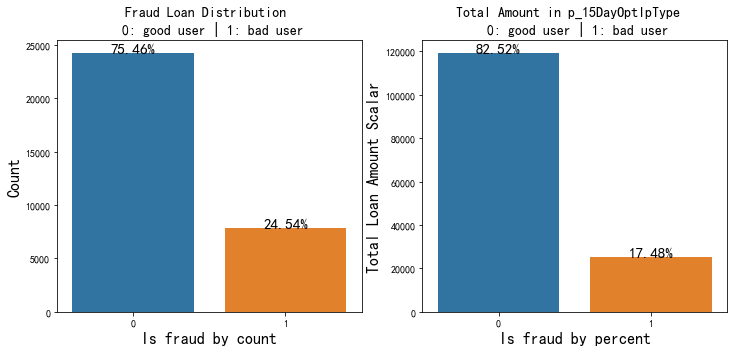

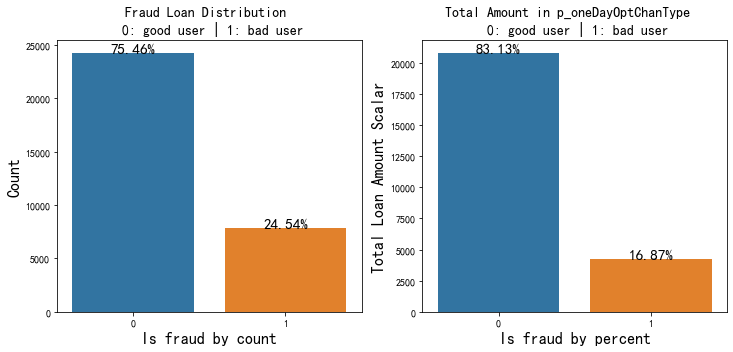

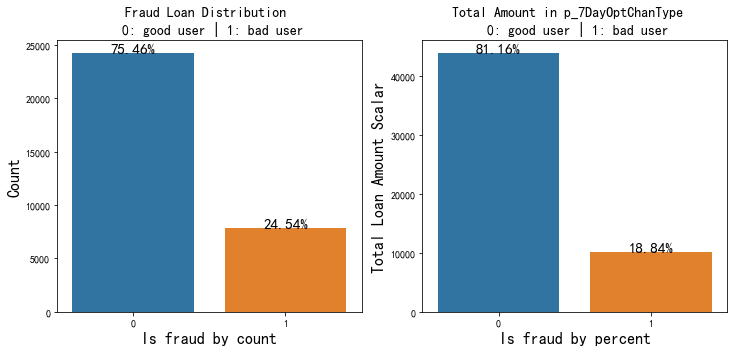

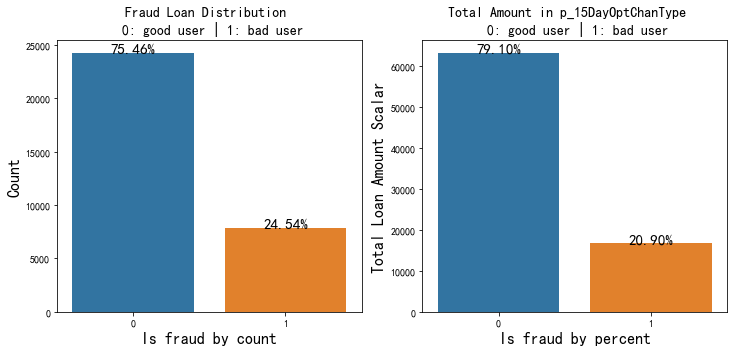

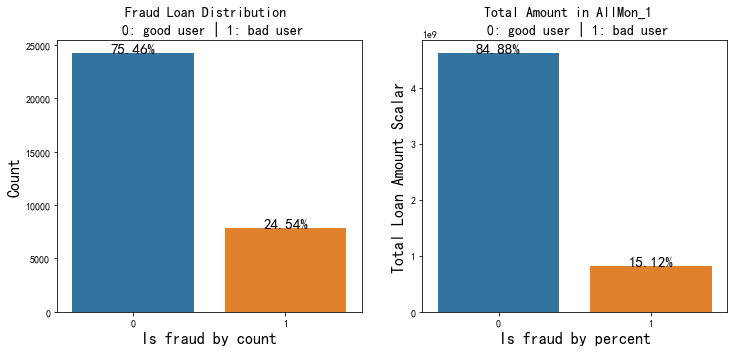

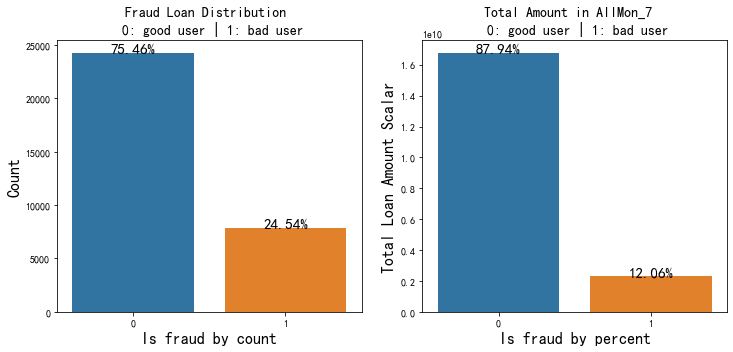

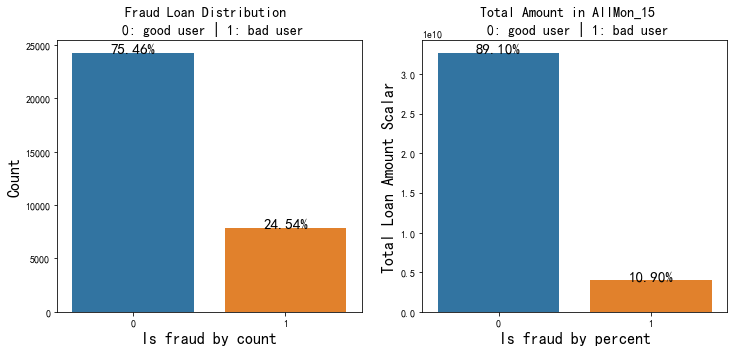

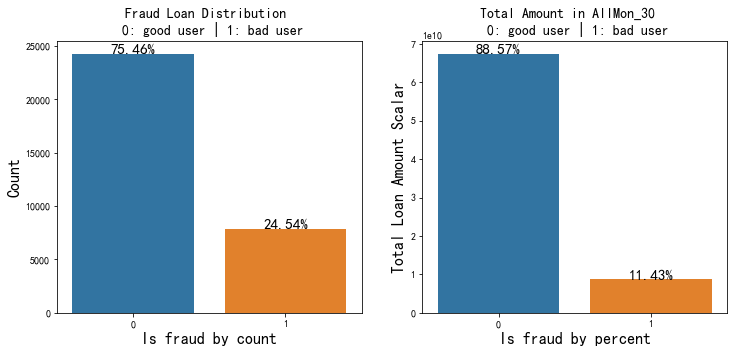

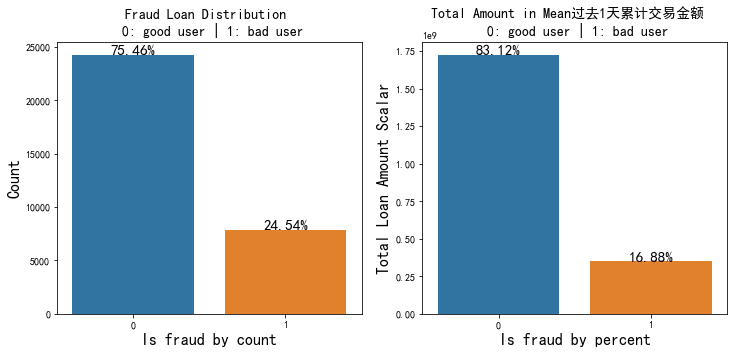

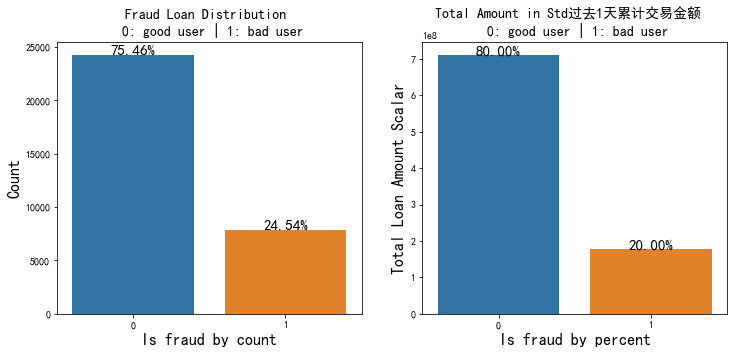

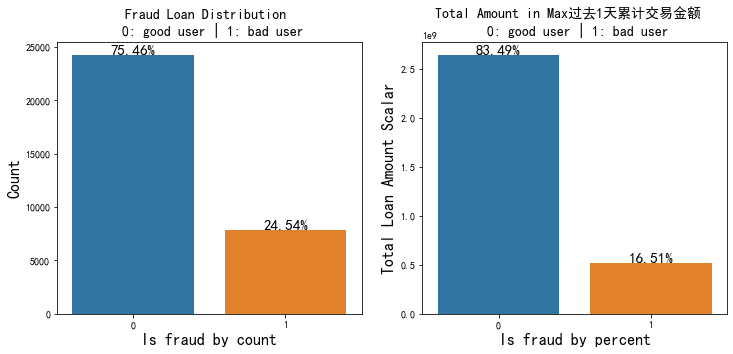

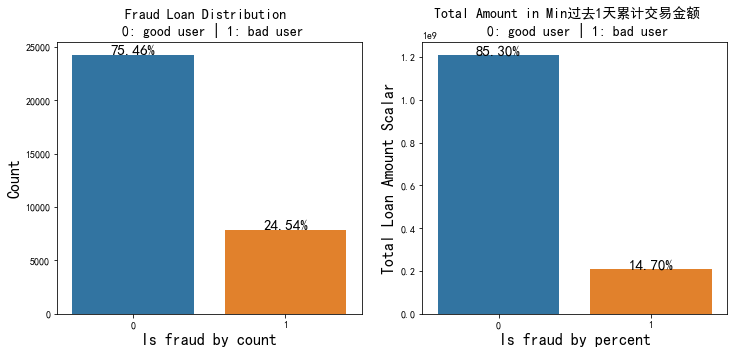

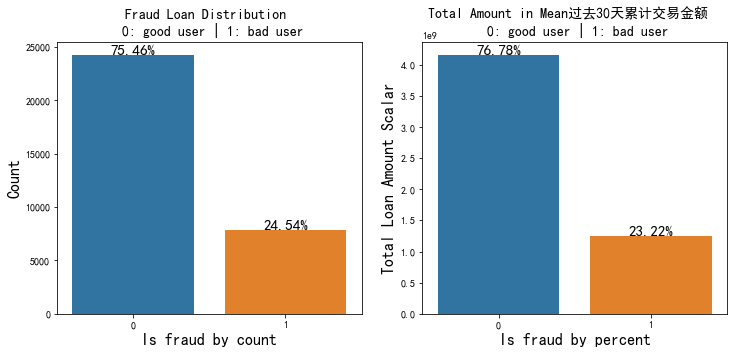

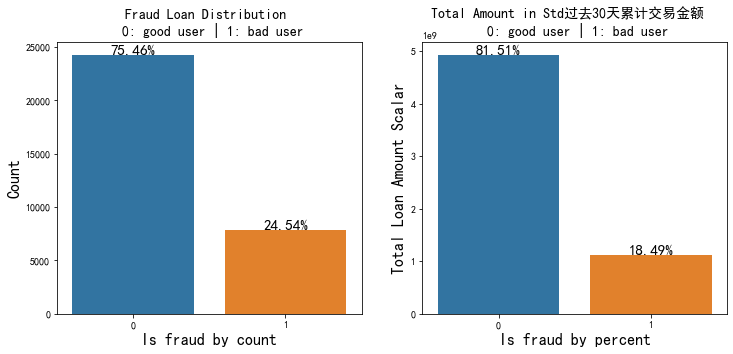

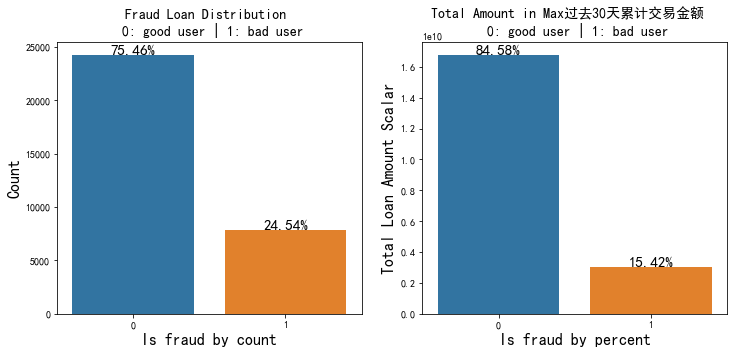

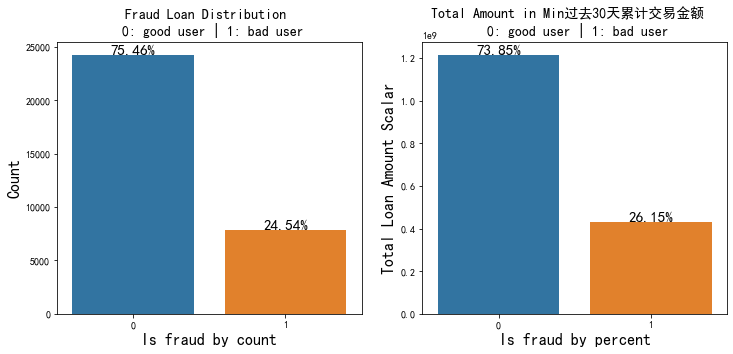

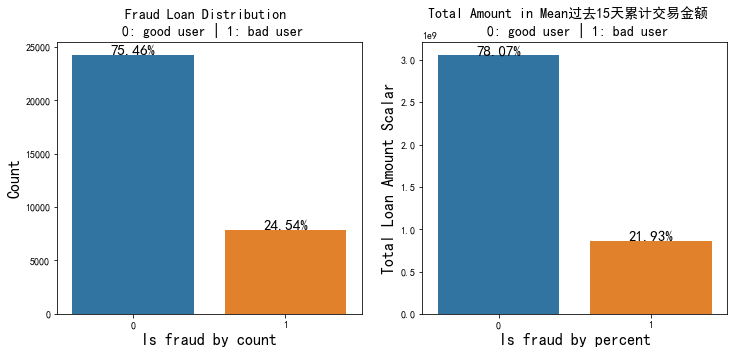

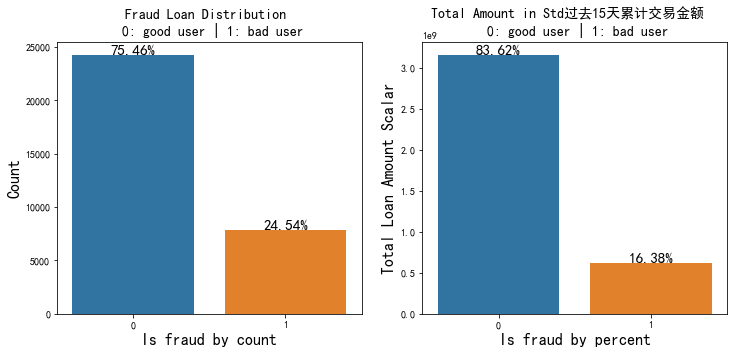

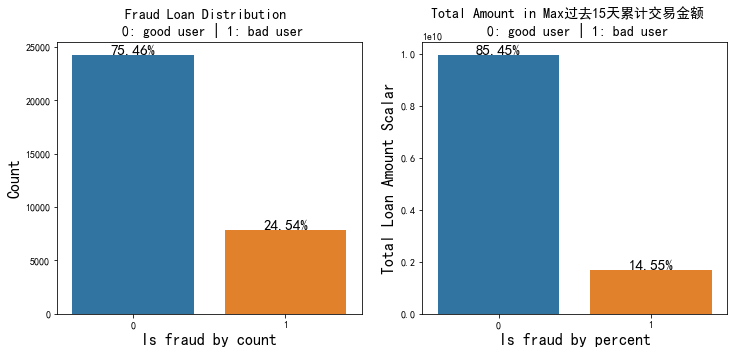

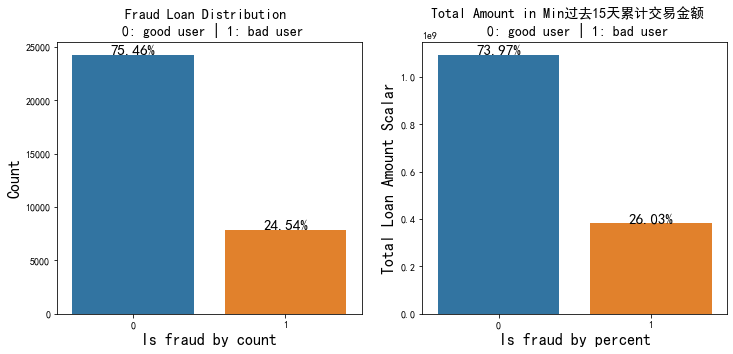

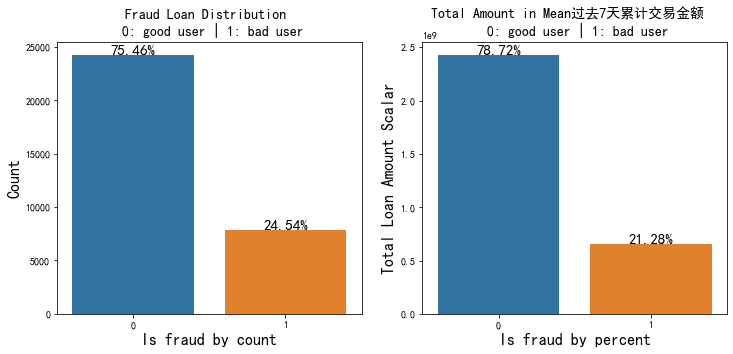

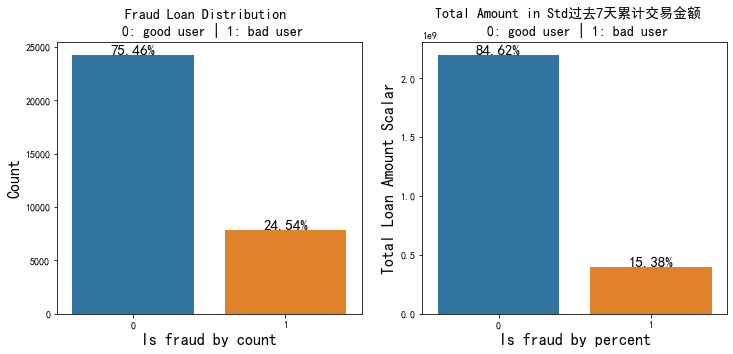

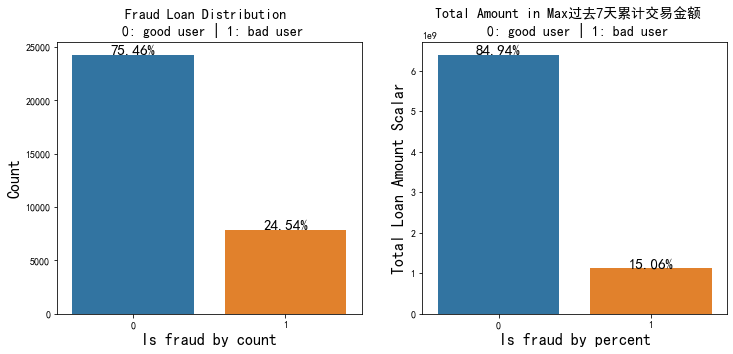

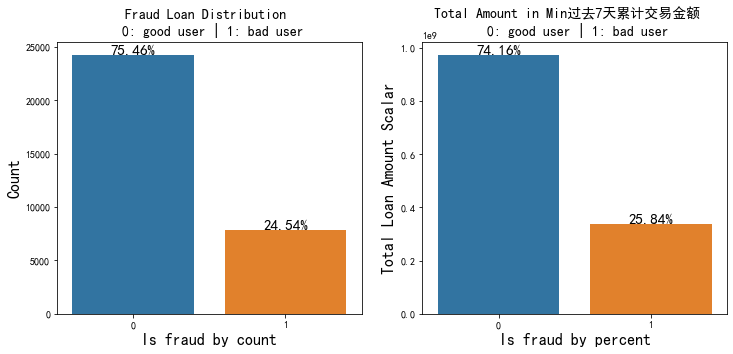

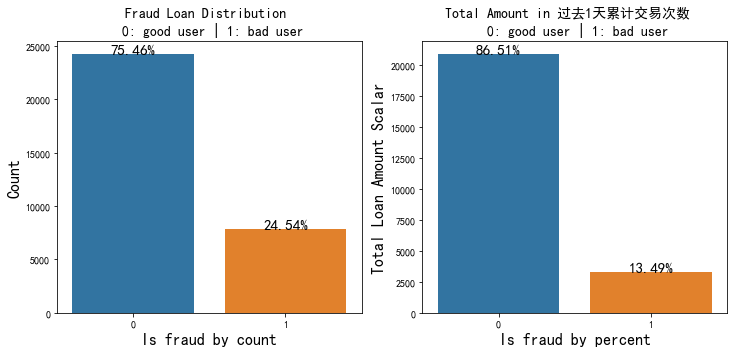

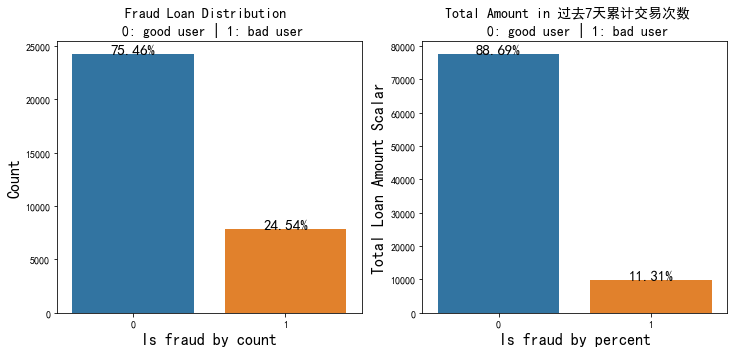

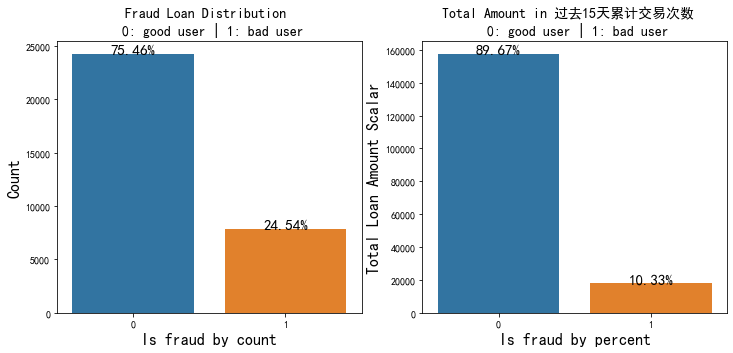

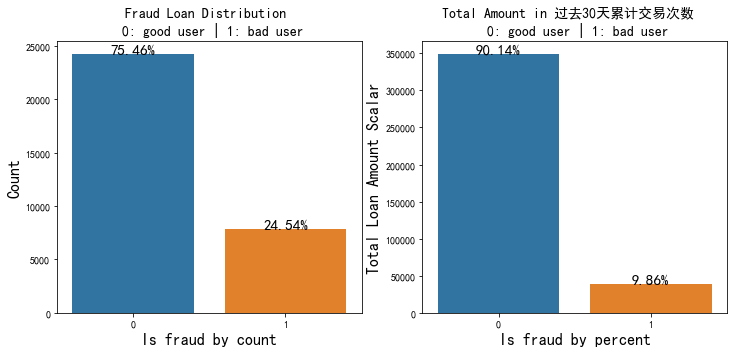

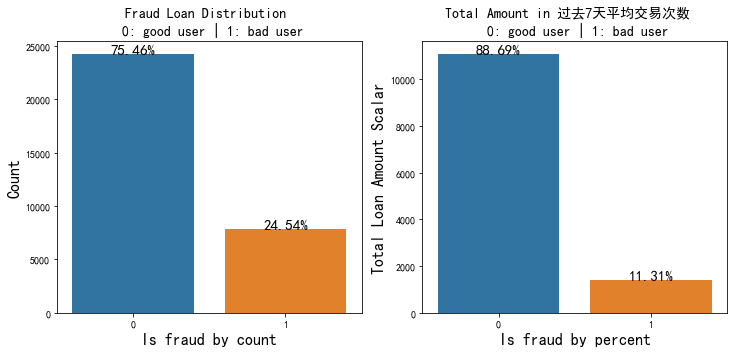

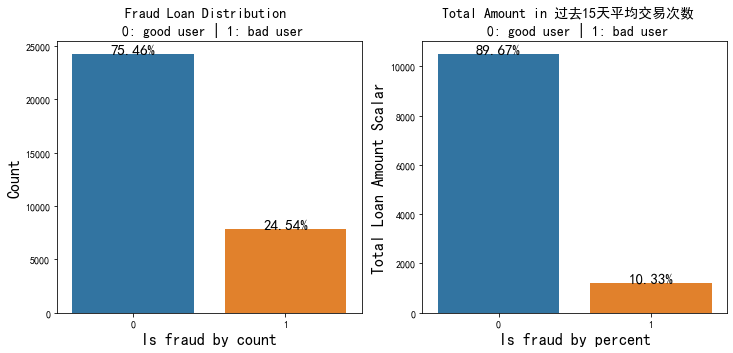

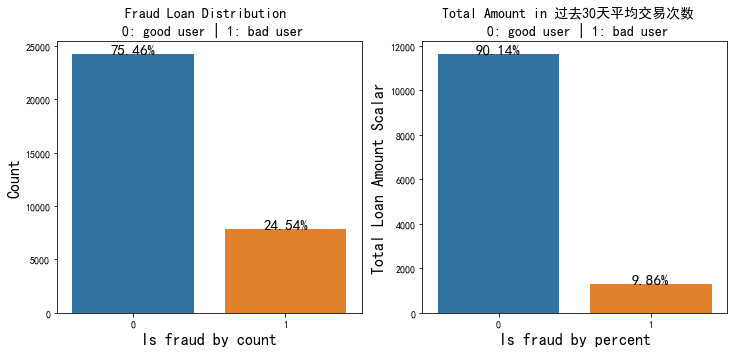

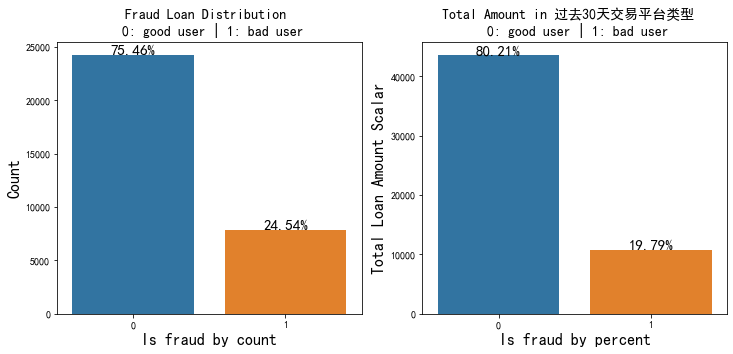

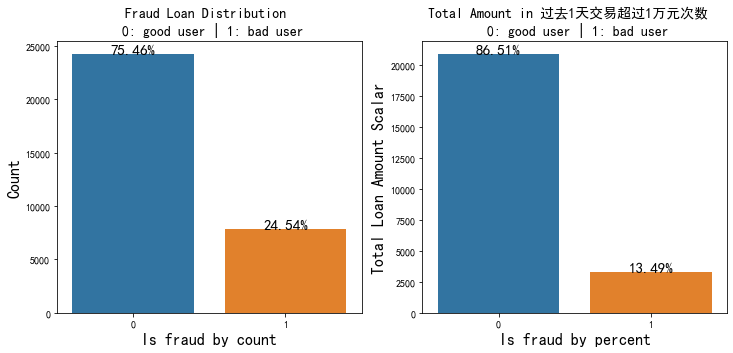

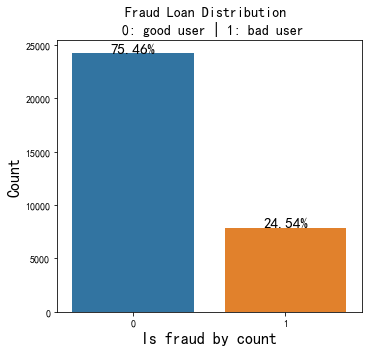

In [20]:
for fea in numerical_fea:
    plot_dis_num(fea)

## 数据预处理

1. 缺失值处理：先尝试填补成0
2. 数据标准化：把表示金额的数据列拿出来进行标准化
3. 采样 -- 做数据扩充 -- 正负样本重新拼接成一个子样本

## 过采样

In [ ]:
from imblearn.over_sampling import SVMSMOTE,SMOTE
from collections import  Counter

class imbalancedData():
    def __init__(self,train,test,mmin,mmax,flag,lis=[]):
        self.flag = flag
        self.train_x = train.drop([flag]+lis,axis=1)
        self.train_y = train[flag]
        print('Original dataset shape %s' % Counter(self.train_y))
        self.test_x = test.drop([flag]+lis,axis=1)
        self.test_y = test[flag]
        self.columns = list(self.train_x.columns)
        self.keep = self.columns + [self.flag]
        self.mmin = 0.1 #低分段错分比例
        self.mmax = 0.7 # 高分段错分比例
    """
    0.1:噪声权重
    1:正常样本权重
    """
    def weight(self,x,y):
        if x==0 and y<self.mmin:
            return 0.1
        elif x==1 and y>self.mmax:
            return 0.1
        else:
            return 1
    def lgb_test(self):
        clf = lgb.LGBMClassifier(boosting_type='gbdt',
        objective = 'binary',
        metric = 'auc',
        learning_rate = 0.1,
        n_estimators=24,
        max_depth=4,
        num_leaves=25,
        max_bin = 40,
        min_data_in_leaf = 5,
        bagging_fraction=0.6,
        bagging_freq = 0,
        feature_fraction=0.8)
        clf.fit(self.train_x, self.train_y, eval_set = [(self.train_x,self.train_y),(self.test_x,self.test_y)]
        ,eval_metric = 'auc')
        return clf,clf.best_score_['valid_1']['auc']

    def data_cleaning(self):
        lgb_model,lgb_auc = self.lgb_test()
        sample = self.train_x.copy()
        sample[self.flag] = self.train_y
        
        sample['pred'] = lgb_model.predict_proba(self.train_x)[:,1]

        sample = sample.sort_values(by = ['pred'], ascending= False).reset_index()
        sample['rank'] = np.array(sample.index)/len(sample)

        sample['weight'] = sample.apply(lambda s:self.weight(s[self.flag],s['rank']),axis=1)
        osvp_sample = sample[sample.weight == 1][self.keep]
        osnu_sample = sample[sample.weight < 1][self.keep]

        train_x_osvp = osvp_sample[self.columns]
        train_y_osvp = osvp_sample[self.flag]

        return train_x_osvp,train_y_osvp,osnu_sample
    
    def smote(self,train_x_osvp,train_y_osvp,m=4,K=15,random_state=42):
        # smote = SVSMOTE(k_neighbors=K,kind='borderline1',m_neighbors=m,
        # n_jobs = 1,out_step='deprecated', random_state=random_state,ratio=None,
        # svm_estimator='deprecated')
        
        # smote = SMOTE(random_state=random_state, k_neighbors=K,n_jobs=None)

        smote = BorderlineSMOTE(k_neighbors=K,m_neighbors=m,
        n_jobs = 1, random_state=random_state)
        
        rex,rey = smote.fit_resample(train_x_osvp,train_y_osvp)

        return rex,rey

    def apply_smote(self):
        train_x_osvp,train_y_osvp ,osnu_sample = self.data_cleaning()
        rex,rey = self.smote(train_x_osvp,train_y_osvp)
        print('Resampled dataset shape %s' % Counter(rey))
        print('badpctn:',rey.sum()/len(rey))
        df_rex = pd.DataFrame(rex)
        df_rex.columns = self.columns
        df_rex['weight'] = 1
        df_rex[self.flag] = rey
        df_aff_ovsp = df_rex.append(osnu_sample)
        return df_aff_ovsp
        

     

# 特征工程

In [174]:
numerical_fea.remove('label')

In [177]:
category_fea.remove('user')

In [211]:
test_fea.isnull().sum()

user              0
sex              75
age               0
provider          0
level             0
                 ..
过去7天平均交易次数        0
过去15天平均交易次数       0
过去30天平均交易次数       0
过去30天交易平台类型       0
过去1天交易超过1万元次数     0
Length: 84, dtype: int64

In [212]:
#按照中位数填充数值型特征/或填充0；实验不同的填充方法
train_fea[numerical_fea] = train_fea[numerical_fea].fillna(train_fea[numerical_fea].median())
test_fea[numerical_fea] = test_fea[numerical_fea].fillna(test_fea[numerical_fea].median())
#按照众数填充类别型特征
# data_test_a[category_fea] = data_test_a[category_fea].fillna(train_fea[category_fea].mode())

In [268]:
train_fea['sex'] = train_fea['sex'].fillna(0) # 使用众数填充?

In [213]:
category_fea

_2Class = ['sex','verified','agreement1','agreement2','agreement3','agreement4']
_place = ['province','city']
_multiClass = category_fea[11:]+['provider','level','regist_type']


两类且有优先级别的编码的转化

In [214]:

for data in [train_fea, test_fea]:
    for fea in _2Class:
        data[fea] = data[fea].map({'category 0':0,'category 1':1})

In [216]:
for f in _multiClass:
    print(f, '类型数：', train_fea[f].nunique())

balance 类型数： 20
balance_avg 类型数： 21
balance1 类型数： 21
balance1_avg 类型数： 21
balance2 类型数： 20
balance2_avg 类型数： 5
service3 类型数： 2
service3_level 类型数： 4
product1_amount 类型数： 7
product2_amount 类型数： 21
product3_amount 类型数： 3
product4_amount 类型数： 2
product5_amount 类型数： 2
product6_amount 类型数： 21
provider 类型数： 3
level 类型数： 3
regist_type 类型数： 8


多类，有大小等级的编码的转化

In [219]:
for data in [train_fea, test_fea]:
    data = pd.get_dummies(data, columns=_multiClass, drop_first=True)

### 【TODO城市和省份编码的转化】 -- 是否高危城市 -- 二值编码

In [230]:
from sklearn.preprocessing import LabelEncoder
for col in _multiClass:
    le = LabelEncoder()
    le.fit(list(train_fea[col].astype(str).values) + list(test_fea[col].astype(str).values))
    train_fea[col] = le.transform(list(train_fea[col].astype(str).values))
    test_fea[col] = le.transform(list(test_fea[col].astype(str).values))
print('Label Encoding 完成')

Label Encoding 完成


In [260]:
# numerical_fea.remove('age')

## 异常值处理【待理解】


test的异常值不能删去；

In [261]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])

    outliers_cut_off = data_std * 3
    
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [277]:
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(train_fea,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['label'].sum())
    print('*'*10)

正常值    32116
异常值       41
Name: using_time_outliers, dtype: int64
using_time_outliers
异常值       0
正常值    7890
Name: label, dtype: int64
**********
正常值    31739
异常值      418
Name: card_a_cnt_outliers, dtype: int64
card_a_cnt_outliers
异常值      44
正常值    7846
Name: label, dtype: int64
**********
正常值    31514
异常值      643
Name: card_b_cnt_outliers, dtype: int64
card_b_cnt_outliers
异常值      66
正常值    7824
Name: label, dtype: int64
**********
正常值    31564
异常值      593
Name: card_c_cnt_outliers, dtype: int64
card_c_cnt_outliers
异常值      74
正常值    7816
Name: label, dtype: int64
**********
正常值    31548
异常值      609
Name: op1_cnt_outliers, dtype: int64
op1_cnt_outliers
异常值      48
正常值    7842
Name: label, dtype: int64
**********
正常值    31819
异常值      338
Name: op2_cnt_outliers, dtype: int64
op2_cnt_outliers
异常值      84
正常值    7806
Name: label, dtype: int64
**********
正常值    31887
异常值      270
Name: card_d_cnt_outliers, dtype: int64
card_d_cnt_outliers
异常值       6
正常值    7884
Name: label, dtype: 

箱型图

### 特征分箱

In [ ]:
# toad库不太好调整分箱；试着尝试不同的方法进行分箱

import math
class charWoe(object):
    def __init__(self,datasets,dep,weight,vars):
        self.datasets = datasets
        self.devf = datasets.get("dev","")
        self.valf = datasets.get("val","")
        self.offf = datasets.get("off","")
        self.weight = weight
        self.vars = vars # 参与建模的特征名
        self.nrows , self.ncols = self.devf.shape
    def char_woe(self):
        
        dic = dict(self.devf.groupby([self.dep]).size())
        good = dic.get(0,0) + 1e-10
        bad = dic.get(1,0) + 1e-10

        for col in self.vars:
            
        
        

### 特征筛选

In [ ]:
# 可以做树模型/相关系数/KS值/PSI值/RFE递归特征消除/selectKBest
# 筛出一些初步的特征进一步进行训练
# 先试一下基本的操作
# 输出特征的重要性
# 多计算一些特征 -- 
# 评估方法

### 初步尝试训练

In [274]:
from catboost import CatBoostRegressor

In [275]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed) # K折交叉验证

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)

            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [250]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [251]:
features = [f for f in train_fea.columns if f not in ['user','label']+DropFeature+_place]
x_train = train_fea[features]
x_test = test_fea[features]
y_train = train_fea['label']

In [276]:
  cat_train, cat_test = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.4298908	test: 0.4264013	best: 0.4264013 (0)	total: 148ms	remaining: 49m 15s
500:	learn: 0.3954776	test: 0.4075760	best: 0.4075408 (496)	total: 2.24s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4073787926
bestIteration = 644

Shrink model to first 645 iterations.
[0.7038723874716408]
************************************ 2 ************************************
0:	learn: 0.4285308	test: 0.4318719	best: 0.4318719 (0)	total: 10ms	remaining: 3m 20s
500:	learn: 0.3950131	test: 0.4090721	best: 0.4090426 (498)	total: 2.02s	remaining: 1m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4089416827
bestIteration = 593

Shrink model to first 594 iterations.
[0.7038723874716408, 0.7185276199846539]
************************************ 3 ************************************
0:	learn: 0.4294079	test: 0.4284658	best: 0.4284658 (0)	total: 8.92ms	remainin

TypeError: cannot unpack non-iterable NoneType object

In [252]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.65678	eval-auc:0.64238
[200]	train-auc:0.77375	eval-auc:0.70326
[400]	train-auc:0.82191	eval-auc:0.70386
[479]	train-auc:0.83666	eval-auc:0.70369
[0.7043183260234257]
************************************ 2 ************************************
[00:18:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being 

In [244]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.888885	valid_1's auc: 0.696102
Early stopping, best iteration is:
[79]	training's auc: 0.810519	valid_1's auc: 0.700564
[0.7005637748367595]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.892861	valid_1's auc: 0.70699
Early stopping, best iteration is:
[60]	training's auc: 0.792596	valid_1's auc: 0.715009
[0.7005637748367595, 0.7150093103099757]
************************************ 3 **

# 训练

In [3]:
Xtr_1,Xts_1,Ytr_1,Yts_1 = train_test_split(train_fea.drop(["user","label"],axis=1),train_fea["label"],test_size=0.25,random_state=2000)

In [ ]:
XGB1_a = xgb.XGBClassifier(enable_categorical=True)
XGB1_a.fit(Xtr_1, Ytr_1)
score1_tr_x0 = XGB1_a.score(Xtr_1, Ytr_1)
score1_ts_x0 = XGB1_a.score(Xts_1, Yts_1)

In [ ]:
all_list = list(train_fea.columns)
NotUseFea = ['user','label']
feature_lst = list(filter(lambda x: x not in NotUseFea,all_list))


In [ ]:

x = train_fea[feature_lst]
y = train_fea['label']

y_pred = XGB1_a.predict_proba(x)[:,1]

# percision

# recall

# F1-Score

# 返回值分别是假正例率和真正例率
fpr_lr_train,tpr_lr_train , _ = roc_curve(y,y_pred)

train_ks = abs(fpr_lr_train - tpr_lr_train).max()

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label='train LR')
# plt.plot(fpr_lr_val,tpr_lr_val,label='val LR')
# plt.plot([0,1],[0,1],'k--')
plt.plot([0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()